In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn

Постановка задачи

Задача классификации - зависимость года от типа топлива, типа кузова цены, пробега и объёма двигателя.

In [35]:
data = pd.read_csv("2cars_moldova.csv")
rows = data.shape[0]
columns = data.shape[1]

print("Строки - ", rows)
print("Столбцы - ", columns)
data.head(20)

Строки -  41007
Столбцы -  9


,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,NaN,NaN,Automatic,7750.0
1,Renault,NaN,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,NaN,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
5,Mercedes,Vito,NaN,Microvan,300000.0,2200.0,Diesel,NaN,3490.0
6,Volkswagen,Passat,2010.0,Universal,290000.0,1390.0,Petrol,Manual,5600.0
7,Volkswagen,Touareg,2010.0,SUV,220000.0,NaN,Diesel,Automatic,17000.0
8,Mercedes,Series (W124),1991.0,Sedan,240000.0,2300.0,Petrol,Manual,2850.0
9,BMW,5 Series,2004.0,Sedan,325000.0,300.0,Diesel,Manual,3400.0


Подготовка данных

Удалим строки с пустыми ячейками и нормализуем

In [36]:
# В начале удалим строки с пустыми значениями
data = data.dropna()

In [37]:
# В среднем автомобиль стоит на конвеере 10 лет поэтому отбросим автомобили, которые были выпущены до 1990 года и распределим год следующим образом
# Функция для присвоения категории в зависимости от года
def categorize_year(year):
    if year < 1990:
        return None  # Помечаем года менее 1990 для удаления
    elif 1990 < year < 2000:
        return 1
    elif 2000 < year <= 2010:
        return 2
    elif 2010 < year <= 2020:
        return 3
    else:
        return 4

# Применение функции к столбцу "Year"
data['Year'] = data['Year'].apply(categorize_year)

# Удаление строк, где год меньше 1990
data = data.dropna()

Корректировка типов

In [38]:
data['Fuel_type'].replace(['Electric', 'Petrol', 'Plug-in Hybrid', 'Diesel', 'Metan/Propan', 'Hybrid'], [0, 1, 2, 3, 4, 5], inplace=True)
data['Fuel_type'] = data['Fuel_type'].astype('int64')

data['Style'].replace(['Hatchback', 'Universal', 'Coupe', 'Cabriolet', 'SUV', "Roadster", "Combi", "Sedan", "Pickup", "Minivan", "Crossover", "Microvan"], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], inplace=True)
data['Style'] = data['Style'].astype('int64')

До обработки данные содержали 41007 строк. После - 23209

Убедимся что нет пустых строк и ячеек

In [39]:
total_rows = len(data)
empty_rows = data.isnull().all(axis=1).sum()
percentage_empty = (empty_rows / total_rows) * 100
print(f"Percentage of empty rows: {percentage_empty:.2f}%")

Percentage of empty rows: 0.00%


In [40]:
# Количественные признаки
data.describe()

,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Price(euro)
count,23209.000000,23209.000000,2.320900e+04,23209.000000,23209.000000,23209.000000
mean,2.404326,4.966349,4.528595e+05,1853.611961,2.484123,9629.298763
std,0.719305,3.673430,4.442151e+06,696.255559,1.241385,10358.096966
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000,5.000000
25%,2.000000,1.000000,8.965600e+04,1500.000000,1.000000,3599.000000
50%,2.000000,7.000000,1.690000e+05,1800.000000,3.000000,6750.000000
75%,3.000000,7.000000,2.300000e+05,2000.000000,3.000000,12300.000000
max,4.000000,11.000000,1.000000e+08,9999.000000,5.000000,215000.000000


Корреляционная матрица

Year-Price: 0.40939031061091524


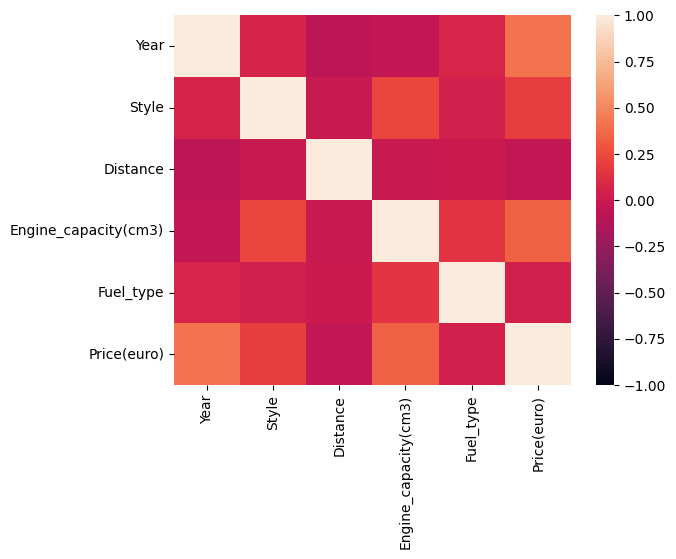

In [41]:
corrMat = data.corr(numeric_only=True)
sns.heatmap(corrMat, vmin=-1.0, vmax=1.0)

print("Year-Price:", corrMat["Year"]["Price(euro)"])

Видно что цена зависит от года выпуска.

Text(0, 0.5, 'Engine_capacity(cm3)')

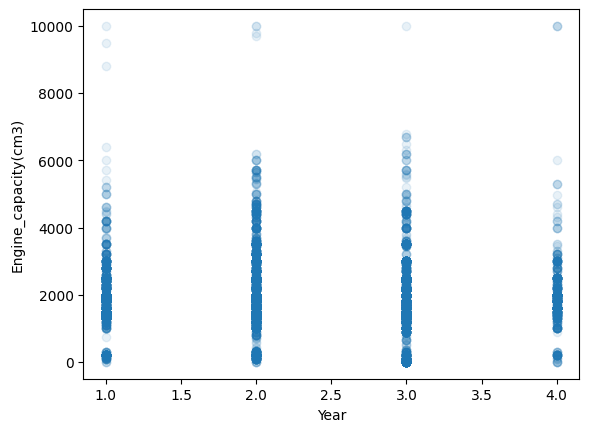

In [42]:
plt.scatter(data['Year'], data['Engine_capacity(cm3)'], alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Engine_capacity(cm3)')

Видно, что чем меньше год выпуска, тем меньше разброс по объему мотора

Text(0, 0.5, 'Year')

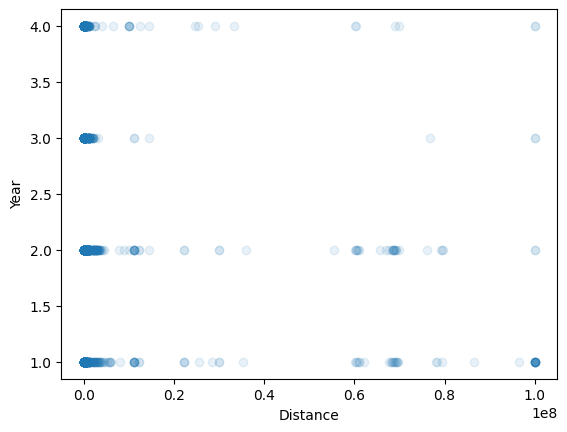

In [43]:
plt.scatter(data['Distance'], data['Year'], alpha=0.1)
plt.xlabel('Distance')
plt.ylabel('Year')

Видно, что пробеш зависит от года выпуска автомобиля.

Text(0, 0.5, 'Year')

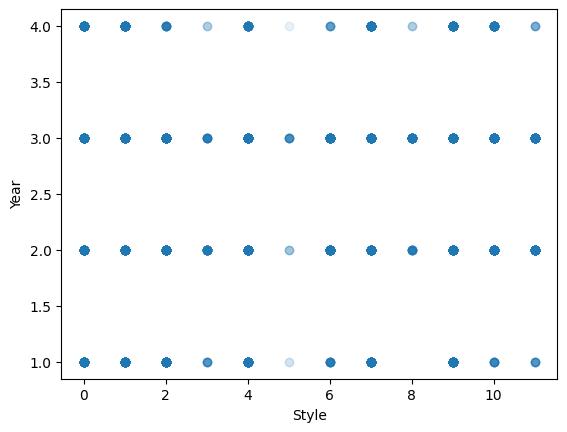

In [44]:
plt.scatter(data['Style'], data['Year'], alpha=0.1)
plt.xlabel('Style')
plt.ylabel('Year')

Видно, что у новых автомобилей уменьшилось разнообразие в кузовах

Классы Будем классифицировать по году выпуска

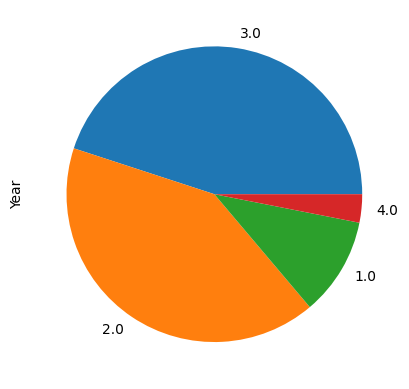

In [45]:
import collections
data['Year'].value_counts().plot.pie();

Нормализация позволит повысить скорость сходимости алгоритма.

Нормализуем данные

In [46]:
# Выделение признаков и целевой переменной
cls = data['Year']
numerical_columns = ["Price(euro)", "Engine_capacity(cm3)"]
norm_columns = ['Fuel_type', 'Style']
nonnorm_columns = ['Engine_capacity(cm3)', 'Distance', "Price(euro)"]
data_nonnorm = data[nonnorm_columns]
data_norm = (data[norm_columns] - data[norm_columns].mean(axis=0)) / data[norm_columns].std(axis=0)
data = pd.concat([data_norm, data_nonnorm], axis=1)



data.head(10)

,Fuel_type,Style,Engine_capacity(cm3),Distance,Price(euro)
2,-1.195537,-1.351965,1400.0,1.0,2200.0
4,1.221118,-1.079740,1600.0,200000.0,4100.0
6,-1.195537,-1.079740,1390.0,290000.0,5600.0
8,-1.195537,0.553611,2300.0,240000.0,2850.0
9,0.415566,0.553611,300.0,325000.0,3400.0
10,0.415566,0.553611,2200.0,210000.0,11400.0
11,0.415566,-0.807515,3200.0,300000.0,11800.0
12,-1.195537,-1.079740,1300.0,23.0,1550.0
13,-1.195537,0.553611,3500.0,285000.0,3990.0
15,-1.195537,-1.351965,1200.0,150000.0,5500.0


Сделаем выборку

In [47]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(data, cls, test_size=0.3, random_state=45)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (16246, 5)
Test: (6963, 5)


Классификатор ближайших соседей

In [50]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
nnb = [5, 10, 15, 20]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, Y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print("Оптимальное кол-во соседей - ", best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, Y_train)

err_train = np.mean(Y_train != knn.predict(X_train))
err_test  = np.mean(Y_test  != knn.predict(X_test))

print("Ошибка на тренировочном наборе - ", err_train)
print("Ошибка на тестовом наборе - ", err_test)


Оптимальное кол-во соседей -  15
Ошибка на тренировочном наборе -  0.22227009725470886
Ошибка на тестовом наборе -  0.24500933505672842
CPU times: user 7.82 s, sys: 105 ms, total: 7.93 s
Wall time: 11.9 s


Выводы

В данной задаче были нормализованы данные, удалены пустые строки.
После изучения корреляционной матрицы были получены данные о зависимости столбцов. Цена зависит от года выпуска автомобиля.
Классификатор ближайших соседей показал ошибку на тестовом наборе 0.22 (Время - 7.82 сек)

задание на 28.12

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, Y_train)


y_pred = lr_model.predict(X_test)

lr_accuracy = accuracy_score(Y_test, y_pred)
lr_error = 1 - lr_accuracy

print("Процент ошибок:", lr_error)

Процент ошибок: 0.25089760160850205


In [52]:
from sklearn.ensemble import RandomForestClassifier

best_error = 1.0
best_n_estimators = 2

for n_estimators in range(2, 50):
    rf_model = RandomForestClassifier(n_estimators=n_estimators)
    rf_model.fit(X_train, Y_train)
    accuracy = rf_model.score(X_test, Y_test)
    error = 1 - accuracy

    if error < best_error:
        best_error = error
        best_n_estimators = n_estimators

print("Best Error:", best_error)
print("Best n_estimators:", best_n_estimators)

Best Error: 0.16501507970702278
Best n_estimators: 39


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np

def train_evaluate_mlp(X_train, Y_train, X_test, Y_test, alpha):
    # Создание MLP модели с заданными параметрами
    mlp_model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(100,),
                              solver='lbfgs', activation='logistic', max_iter=10, random_state=42)

    # Обучение модели на тренировочных данных
    mlp_model.fit(X_train, Y_train)

    # Получение предсказаний для тренировочного и тестового наборов
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    # Расчет ошибок и точности для тренировочного и тестового наборов
    train_error = np.mean(Y_train != y_train_pred)
    test_error = np.mean(Y_test != y_test_pred)
    train_accuracy = accuracy_score(Y_train, y_train_pred)
    test_accuracy = accuracy_score(Y_test, y_test_pred)

    return train_error, test_error, train_accuracy, test_accuracy

# Создание массива значений alpha в логарифмической шкале
alpha_arr = np.logspace(-5, 2, 50)

# Инициализация массивов для хранения результатов
test_errors = []
train_errors = []
train_accuracies = []
test_accuracies = []

# Итерация по значениям alpha и оценка модели
for alpha in alpha_arr:
    train_err, test_err, train_acc, test_acc = train_evaluate_mlp(X_train, Y_train, X_test, Y_test, alpha)

    # Добавление результатов в массивы
    train_errors.append(train_err)
    test_errors.append(test_err)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

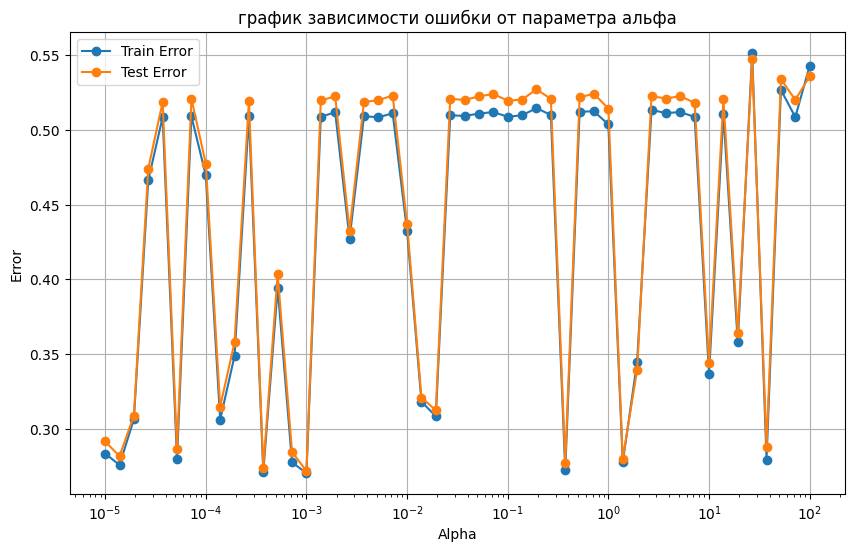

In [23]:
# Создание массива значений alpha в логарифмической шкале
alpha_values = np.logspace(-5, 2, 50)

# Построение графика зависимости ошибки от параметра alpha
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_errors, label='Train Error', marker='o')
plt.semilogx(alpha_values, test_errors, label='Test Error', marker='o')

# Добавление легенды и подписей к осям
plt.legend()
plt.title('Learning Curve for MLPClassifier')
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.title('график зависимости ошибки от параметра альфа')
plt.grid(True)
plt.show()

In [14]:
# Находим минимальные ошибки на тренировочном и тестовом наборах
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)

# Находим индекс оптимального значения alpha на основе минимальной ошибки на тестовом наборе
alpha_opt_idx = np.argmin(test_err)

# Находим оптимальное значение alpha на основе индекса
alpha_opt = alpha_arr[alpha_opt_idx]

# Выводим результаты на экран
print("Минимальная ошибка на тренировочных данных: ", min_train_err)
print("Минимальная ошибка на тестовых данных: ", min_test_err)
print("Оптимальное значение alpha: ", alpha_opt)

Минимальная ошибка на тренировочных данных:  0.27046657638803395
Минимальная ошибка на тестовых данных:  0.2718655751831107
Оптимальное значение alpha:  0.001


In [15]:
# Создание и настройка MLP модели с оптимальными параметрами
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(100,),
                          solver='lbfgs', activation='logistic', random_state=42)

# Обучение модели на тренировочных данных
mlp_model.fit(X_train, Y_train)

# Расчет ошибки на тренировочном наборе данных
train_error = np.mean(Y_train != mlp_model.predict(X_train))

# Расчет ошибки на тестовом наборе данных
test_error = np.mean(Y_test != mlp_model.predict(X_test))

# Вывод ошибок на экран
print("Ошибка на тренировочных данных: ", train_error)
print("Ошибка на тестовых данных: ", test_error)


Ошибка на тренировочных данных:  0.25821740736181215
Ошибка на тестовых данных:  0.2599454258222031


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

def train_mlp_classifier(X_train, Y_train, alpha_opt=alpha_opt):
    # Создание и обучение MLP модели
    mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(100,),
                              solver='lbfgs', activation='logistic', random_state=42)
    mlp_model.fit(X_train, Y_train)
    return mlp_model

def evaluate_model(model, X, y, dataset_name):
    # Получение предсказаний на основе модели
    y_pred = model.predict(X)

    # Расчет точности (accuracy)
    accuracy = accuracy_score(y, y_pred)

    # Вывод точности на экран
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")

# Обучение MLP модели на тренировочных данных
mlp_model = train_mlp_classifier(X_train, Y_train)

# Оценка точности модели на тренировочном наборе данных
evaluate_model(mlp_model, X_train, Y_train, "Train")

# Оценка точности модели на тестовом наборе данных
evaluate_model(mlp_model, X_test, Y_test, "Test")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Train Accuracy: 0.7488
Test Accuracy: 0.7478


In [17]:
def train_and_evaluate_neurons(X_train, Y_train, X_test, Y_test, alpha_opt=alpha_opt, start_neurons=50, end_neurons=90):
    # Инициализация переменных для хранения лучшего числа нейронов и соответствующих ошибок
    best_neurons = start_neurons
    best_err_test = 1
    err_test_array = []
    err_train_array = []

    # Цикл по указанному диапазону нейронов
    for neurons in range(start_neurons, end_neurons):
        # Создание модели MLP с текущим числом нейронов
        mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(neurons,),
                                  solver='lbfgs', activation='logistic', random_state=42)
        # Обучение модели на тренировочных данных
        mlp_model.fit(X_train, Y_train)

        # Получение предсказаний для тестового и тренировочного наборов
        y_test_pred = mlp_model.predict(X_test)
        y_train_pred = mlp_model.predict(X_train)

        # Расчет коэффициентов ошибок для тестового и тренировочного наборов
        err_test = np.mean(Y_test != y_test_pred)
        err_train = np.mean(Y_train != y_train_pred)

        # Добавление ошибок в массивы для последующего анализа
        err_test_array.append(err_test)
        err_train_array.append(err_train)

        # Обновление лучшего числа нейронов, если текущая модель имеет более низкую ошибку на тесте
        if err_test < best_err_test:
            best_err_test = err_test
            best_neurons = neurons

    # Возврат лучшего числа нейронов и массивов ошибок
    return best_neurons, err_train_array, err_test_array

# Вызов функции для обучения и оценки нейронов
best_neurons, err_train_array, err_test_array = train_and_evaluate_neurons(X_train, Y_train, X_test, Y_test)

# Вывод результатов
print(f"Лучшее количество нейронов: {best_neurons}")
print(f"Лучшая тестовая ошибка: {min(err_test_array)}")


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Лучшее количество нейронов: 56
Лучшая тестовая ошибка: 0.2478816602039351


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


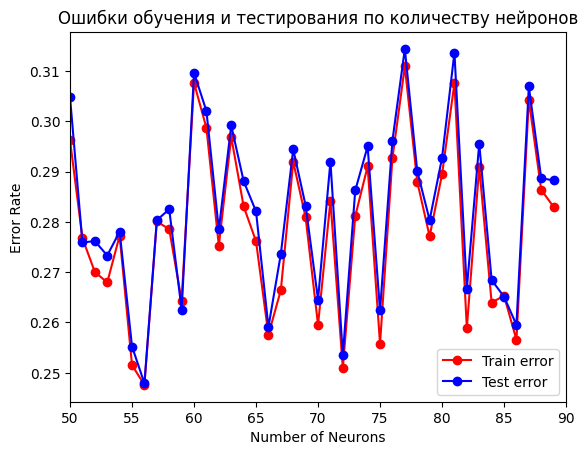

In [18]:
plt.plot(range(50, 90), err_train_array, 'r-o', label='Train error')
plt.plot(range(50, 90), err_test_array, 'b-o', label='Test error')
plt.legend(loc=0)
plt.xlabel('Number of Neurons')
plt.ylabel('Error Rate')
plt.title('Ошибки обучения и тестирования по количеству нейронов')
plt.xlim([50, 90])
plt.show()


In [19]:
# Создание и настройка MLP модели с использованием лучшего числа нейронов
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(best_neurons,),
                          solver='lbfgs', activation='logistic', random_state=42)

# Обучение модели на тренировочных данных
mlp_model.fit(X_train, Y_train)

# Получение предсказаний для тестового и тренировочного наборов
y_test_pred = mlp_model.predict(X_test)
y_train_pred = mlp_model.predict(X_train)

# Расчет коэффициентов ошибок для тестового и тренировочного наборов
err_test = np.mean(Y_test != y_test_pred)
err_train = np.mean(Y_train != y_train_pred)

# Вывод ошибок на экран
print("Ошибка на тесте:", err_test)
print("Ошибка на тренировке:", err_train)

Ошибка на тесте: 0.2766049116760017
Ошибка на тренировке: 0.2716976486519759


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


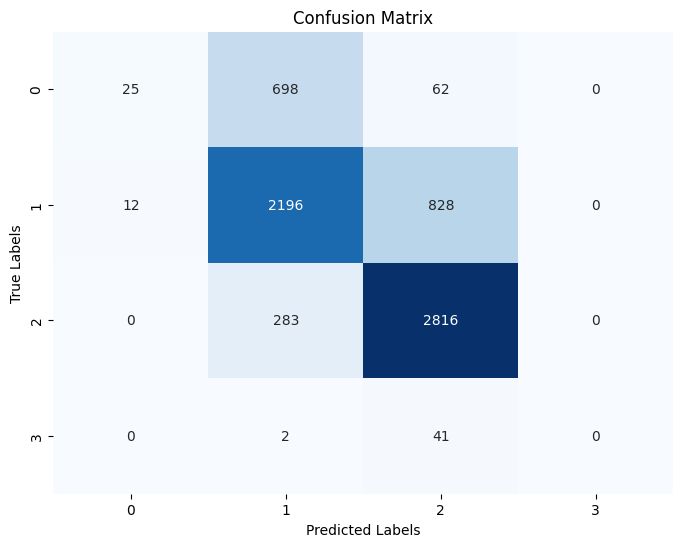

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Выводы:
Наблюдается недообучение, так как процент ошибок больше 10 - это значит что модель является некачественной. Чтобы исправить это, можно увеличить кол-во итерации или увеличить кол-во слоёв.

из матрицы видно, что она лучше всего определяет автомобили c 2000 года по 2010 год

оптимальный параметр alpha = 0.001
лучшее кол-во нейронов = 56

лучший метод randomforest с результатом 0.16
